In [1]:
import os
os.chdir('..')

In [22]:
# import the required libraries
from pump_controller import SilicoPumpController, visualize_rgb, visualize_candidates
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [4]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.acquisition.analytic import ExpectedImprovement

from botorch.optim import optimize_acqf

from warnings import catch_warnings
from warnings import simplefilter

import torch

# SilicoBot Setup

In [5]:
silicobot = SilicoPumpController(noise_std=3)

In [6]:
silicobot.change_target([0.2, 0.2, 0.3, 0.3])

Silico target changed to [127.72452826 132.70329902  79.65275065]. Created by [0.2, 0.2, 0.3, 0.3].


array([127.72452826, 132.70329902,  79.65275065])

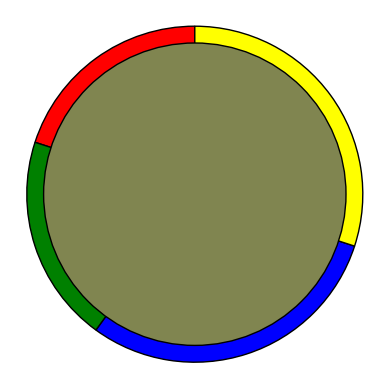

In [10]:
visualize_rgb(silicobot.target_mixture, silicobot.target_color, pump_controller=silicobot, target = None)

In [12]:
print("Target color: ", silicobot.target_color)
print("Target mixture: ", silicobot.target_mixture)

Target color:  [127.72452826 132.70329902  79.65275065]
Target mixture:  [0.2, 0.2, 0.3, 0.3]


# Problem Setup

In [13]:
# Function to calculate the score / error
def color_difference(mixed_color, target_color):
    
    # Calculate the sum of root mean squared differences between mixed color and target color
    rmse = np.sqrt(np.mean((mixed_color - target_color)**2, axis=-1))
    return np.sum(rmse)

In [14]:
# Function to minimize
def objective_function(color_mixture, target_color):
    mixed_color = silicobot.mix_color(color_mixture)
    error = color_difference(mixed_color, target_color)

    return error, mixed_color   

# Generate Random Data

In [16]:
def generate_initial_data(target_color = silicobot.target_color, num_samples = 100):

    # Generate random 100 color mixtures
    # Measure their color
    # Calculate their score

    input_data = np.random.rand(num_samples, 4).astype(np.float64)
    input_data = input_data / np.sum(input_data, axis = 1, keepdims=True)

    output_data_rgb = []
    target_data_rgb = []
    output_data_score = []
    for i in input_data:
        sim_rgb = silicobot.mix_color(i)
        sim_score = color_difference(sim_rgb, silicobot.target_color)

        output_data_rgb.append(sim_rgb)
        target_data_rgb.append(target_color)
        output_data_score.append(sim_score)

    output_data_rgb = np.array(output_data_rgb)
    target_data_rgb = np.array(target_data_rgb)
    output_data_score = np.array(output_data_score)
    output_data_score = output_data_score.reshape(-1,1)

    return input_data, output_data_rgb, target_data_rgb, output_data_score

# Create Model

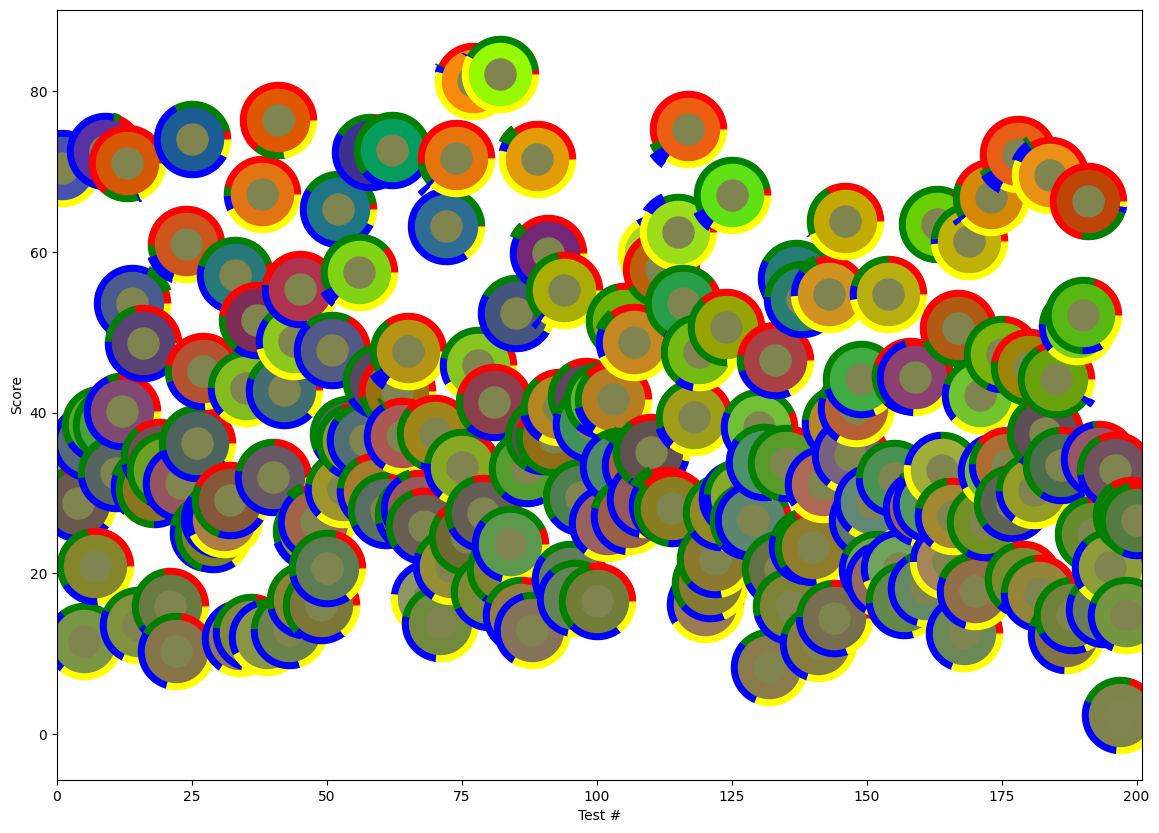

In [81]:
# Generate initial random data
#input_data, output_data_rgb, target_data_rgb, output_data_score = generate_initial_data()
warm_start_data = generate_initial_data(num_samples=200)
train_X = torch.tensor(warm_start_data[0], dtype = torch.double)
Y = torch.tensor(warm_start_data[3], dtype = torch.double)

ty_mean = Y.mean()
ty_std = Y.std()

train_Y = standardize(Y)

visualize_candidates(warm_start_data)

In [82]:
warm_start_data[3][np.argmin(warm_start_data[3])]

array([2.30050013])

In [83]:
mixtures = []
measurements = []
targets = []
scores = []

data = []

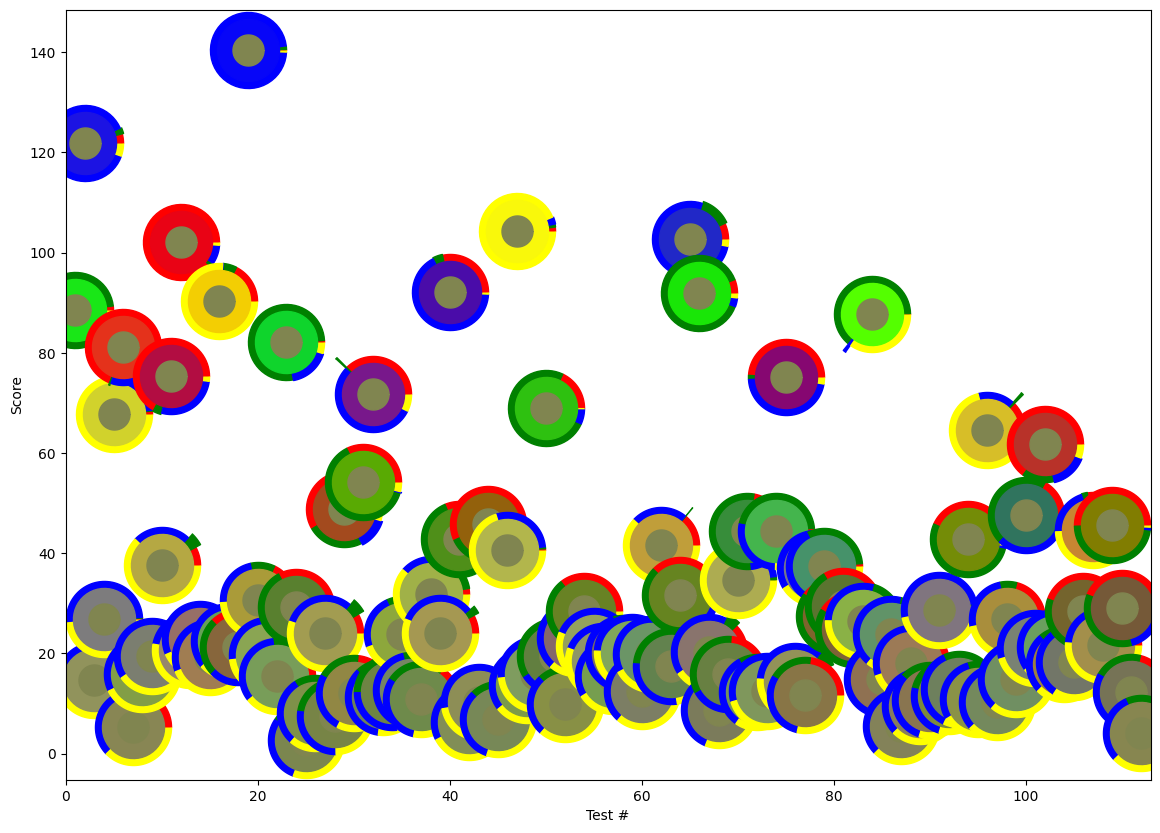

In [87]:
num_restarts = 10
num_steps = 50
max_threshold = 5
target_color = silicobot.target_color
n_func_calls = 11



for step in range(num_steps):
    with catch_warnings():
        simplefilter("ignore")
        gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

    EI = ExpectedImprovement(gp, best_f = train_Y.min(), maximize = False)

    bounds = torch.stack([torch.zeros(4), torch.ones(4)])

    candidate, acq_value = optimize_acqf(
                EI,
                bounds = bounds,
                q = 1,
                num_restarts = num_restarts,
                raw_samples = 19,
                equality_constraints=[(torch.tensor([0,1,2,3], dtype = torch.int), torch.tensor([1,1,1,1], dtype = torch.float), 1.0)]
            )

    next_point = candidate
    next_error, next_color = objective_function(next_point, target_color)

    mixtures.append(np.array(next_point)[0])
    measurements.append(next_color)
    targets.append(target_color)
    scores.append(next_error)

    

    print(f"Candidate {next_point} with Error {next_error}")

    # Update Model
    train_X = torch.cat((train_X, next_point))

    standardized_next_error = (next_error - ty_mean)/ty_std
    train_Y = torch.cat((train_Y, torch.tensor([[standardized_next_error]])))

    if (step + 1) % n_func_calls == 0:

        data = [mixtures, measurements, targets, scores]
        data = [np.array(col) for col in data]

        plt.close('all')
        display.clear_output(wait=True)
        visualize_candidates(data)

    if next_error < max_threshold:

        data = [mixtures, measurements, targets, scores]
        data = [np.array(col) for col in data]

        plt.close('all')
        display.clear_output(wait=True)
        visualize_candidates(data)

        print("Optimization stopped. Reached max threshold")


        break

data = [mixtures, measurements, targets, scores]
data = [np.array(col) for col in data]

plt.close('all')
display.clear_output(wait=True)
visualize_candidates(data)


In [88]:
np.min(scores)

2.8095717465974035

In [89]:
np.argmin(scores)

24